In [25]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [6]:
df = pd.read_csv("USD_RUB Historical Data.csv")

In [7]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,02/17/2023,74.2900,74.8550,75.2445,73.9569,NaN,-0.75%
1,02/16/2023,74.8550,74.5725,74.8878,74.5338,NaN,0.38%
2,02/15/2023,74.5725,73.8000,74.6423,73.7606,NaN,1.05%
3,02/14/2023,73.8000,73.8250,73.9813,73.0566,NaN,-0.03%
4,02/13/2023,73.8250,73.3900,73.8677,73.2064,NaN,0.59%
...,...,...,...,...,...,...,...
1031,01/25/2019,65.9938,65.7634,66.2490,65.7133,NaN,0.35%
1032,01/24/2019,65.7634,66.0805,66.1021,65.6892,NaN,-0.48%
1033,01/23/2019,66.0805,66.5341,66.5350,66.0359,NaN,-0.68%
1034,01/22/2019,66.5341,66.3882,66.6058,66.3882,NaN,0.22%


176
348
520
692
864


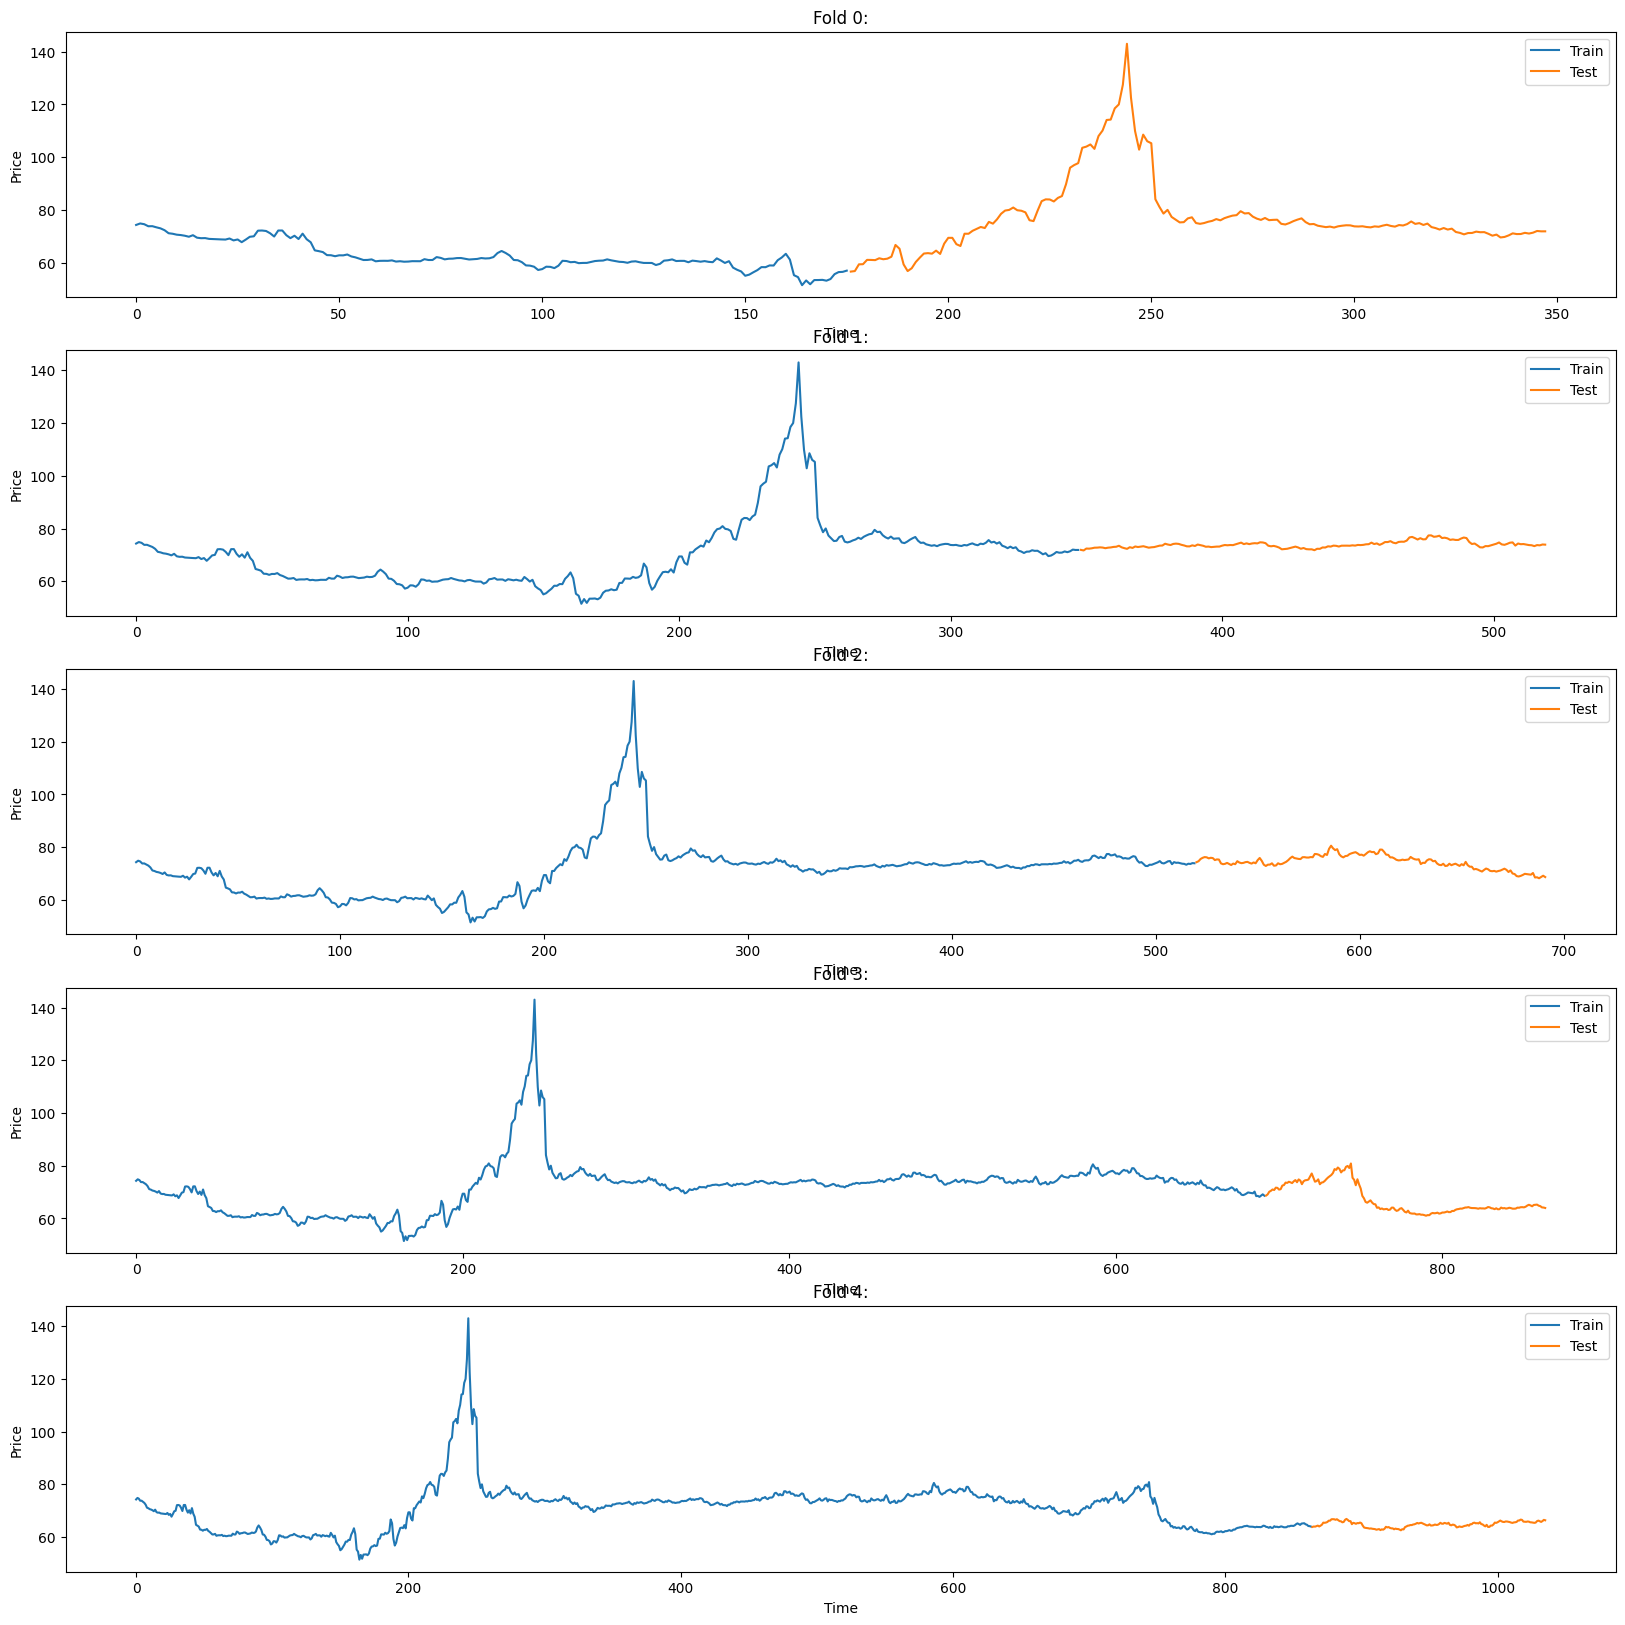

In [22]:
tscv = TimeSeriesSplit()
X = df["Price"]
len_tscv = len([x for x in tscv.split(X)])
fig, ax = plt.subplots(len_tscv, figsize=(20, 20))
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(len(train_index))
    ax[i].set_title(f"Fold {i}:")
    ax[i].plot(X.iloc[train_index], label="Train")
    ax[i].plot(X.iloc[test_index], label="Test")
    
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Price")
    ax[i].legend()

plt.show()

In [26]:
len(X)

1036

In [50]:
# split the data into training and validation sets
train_data = X.iloc[:600]
val_data = X.iloc[600:800]


# define a function to create sequences of input/output pairs
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# convert the data into PyTorch tensors
train_data = torch.from_numpy(train_data.values).float()
val_data = torch.from_numpy(val_data.values).float()

# create sequences of input/output pairs for training and validation
seq_length = 10
train_x, train_y = create_sequences(train_data, seq_length)
val_x, val_y = create_sequences(val_data, seq_length)

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        predictions = self.fc(lstm_out.view(len(input), -1))
        return predictions[-1]

In [57]:
train_x[0], train_y[0]

(tensor([74.2900, 74.8550, 74.5725, 73.8000, 73.8250, 73.3900, 73.0000, 72.3025,
         71.1500, 70.9500]),
 tensor(70.6000))

In [59]:
train_x[1], train_y[1]

(tensor([74.8550, 74.5725, 73.8000, 73.8250, 73.3900, 73.0000, 72.3025, 71.1500,
         70.9500, 70.6000]),
 tensor(70.4550))

In [60]:
# set the hyperparameters
input_size = len(train_x[0])
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 100

# initialize the model
model = LSTM(input_size, hidden_size, output_size)

# set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
# train the model
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    # training
    model.train()
    optimizer.zero_grad()
    outputs = model(train_x)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    
    # validation
    model.eval()
    with torch.no_grad():
        outputs = model(val_x)
        loss = criterion(outputs, val_y)
        val_loss += loss.item()
    
    # print the progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([589])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([189])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Train Loss: 5176.7451, Val Loss: 4965.1812
Epoch [20/100], Train Loss: 5086.3521, Val Loss: 4889.0210
Epoch [30/100], Train Loss: 5025.4263, Val Loss: 4822.3486
Epoch [40/100], Train Loss: 4925.9897, Val Loss: 4728.8252
Epoch [50/100], Train Loss: 4884.1357, Val Loss: 4686.9956
Epoch [60/100], Train Loss: 4837.5396, Val Loss: 4641.1880
Epoch [70/100], Train Loss: 4795.3335, Val Loss: 4599.8003
Epoch [80/100], Train Loss: 4748.6118, Val Loss: 4556.6895
Epoch [90/100], Train Loss: 4706.2690, Val Loss: 4511.5850
Epoch [100/100], Train Loss: 4659.4575, Val Loss: 4465.3589


In [62]:
train_x[:2]

tensor([[74.2900, 74.8550, 74.5725, 73.8000, 73.8250, 73.3900, 73.0000, 72.3025,
         71.1500, 70.9500],
        [74.8550, 74.5725, 73.8000, 73.8250, 73.3900, 73.0000, 72.3025, 71.1500,
         70.9500, 70.6000]])

In [73]:
train_x[:1].shape

torch.Size([1, 10])

In [75]:
# make predictions
model.eval()
with torch.no_grad():
    test_seq = train_x[:3]
    preds = []
    for i in range(len(train_x)):
        model_input = test_seq.view(len(test_seq), 1, -1)
        output = model(model_input)
        print(output.item())

3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104888916
3.9759066104

In [ ]:
# train and evaluate the model using time series cross validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    print(f'Test score: {score:.2f}')